<a href="https://colab.research.google.com/github/KanalaJayareddy/market-sentiment-trader-analysis/blob/main/Market_Sentiment_vs_trader_Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy

In [ ]:
pip install pandas

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
fear_greed_df = pd.read_csv('/content/fear_greed_index.csv')
print(fear_greed_df.head)
trades_df=pd.read_csv('/content/historical_data.csv')
print(trades_df.head)
print(trades_df.columns)

<bound method NDFrame.head of        timestamp  value classification        date
0     1517463000     30           Fear  2018-02-01
1     1517549400     15   Extreme Fear  2018-02-02
2     1517635800     40           Fear  2018-02-03
3     1517722200     24   Extreme Fear  2018-02-04
4     1517808600     11   Extreme Fear  2018-02-05
...          ...    ...            ...         ...
2639  1745818200     54        Neutral  2025-04-28
2640  1745904600     60          Greed  2025-04-29
2641  1745991000     56          Greed  2025-04-30
2642  1746077400     53        Neutral  2025-05-01
2643  1746163800     67          Greed  2025-05-02

[2644 rows x 4 columns]>
<bound method NDFrame.head of                                            Account      Coin  Execution Price  \
0       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107           7.9769   
1       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @107           7.9800   
2       0xae5eacaf9c6b9111fd53034a602c192a04e082ed      @10

In [ ]:
#convert date columns to proper date formate
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])
print(fear_greed_df['date'])
# remove duplicates rows
print(trades_df.drop_duplicates(inplace=True))
# remove rows where important values are missing
print(trades_df.dropna(subset=['Closed PnL','Size USD'],inplace=True))
#Check how many rows remain
print("total trades:",len(trades_df))

0      2018-02-01
1      2018-02-02
2      2018-02-03
3      2018-02-04
4      2018-02-05
          ...    
2639   2025-04-28
2640   2025-04-29
2641   2025-04-30
2642   2025-05-01
2643   2025-05-02
Name: date, Length: 2644, dtype: datetime64[ns]
None
None
total trades: 211224


In [ ]:
# Convert 'Timestamp IST' to datetime objects and extract the date
trades_df['date'] = pd.to_datetime(trades_df['Timestamp IST'], dayfirst=True).dt.date
# Ensure the 'date' column in trades_df is of datetime type for merging
trades_df['date'] = pd.to_datetime(trades_df['date'])
# join trader data with fear/greed data on same date
merged = fear_greed_df.merge(trades_df, left_on='date', right_on='date', how='left')
# create a new column:1 = wining trade, 0 = losing trade
merged['win'] = (merged['Closed PnL'] > 0).astype(int)
print("nan count:'", merged['Closed PnL'].isna().sum())
print(merged.head())

nan count:' 2165
    timestamp  value classification       date Account Coin  Execution Price  \
0  1517463000     30           Fear 2018-02-01     NaN  NaN              NaN   
1  1517549400     15   Extreme Fear 2018-02-02     NaN  NaN              NaN   
2  1517635800     40           Fear 2018-02-03     NaN  NaN              NaN   
3  1517722200     24   Extreme Fear 2018-02-04     NaN  NaN              NaN   
4  1517808600     11   Extreme Fear 2018-02-05     NaN  NaN              NaN   

   Size Tokens  Size USD Side  ... Start Position  Direction Closed PnL  \
0          NaN       NaN  NaN  ...            NaN        NaN        NaN   
1          NaN       NaN  NaN  ...            NaN        NaN        NaN   
2          NaN       NaN  NaN  ...            NaN        NaN        NaN   
3          NaN       NaN  NaN  ...            NaN        NaN        NaN   
4          NaN       NaN  NaN  ...            NaN        NaN        NaN   

   Transaction Hash Order ID  Crossed Fee  Trade ID

In [ ]:
# Group by date + trader + sentiment
# Calculate average PnL, win rate, leverage per day per trader
daily_trader = merged.groupby(
    ['date', 'Account', 'classification', 'value']
).agg(
    daily_pnl    = ('Closed PnL', 'sum'),    # total profit/loss that day
    win_rate     = ('win', 'mean'),          # % of winning trades
    trade_count  = ('Closed PnL', 'count'),  # how many trades
).reset_index()

print(daily_trader.head())

        date                                     Account classification  \
0 2023-05-01  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891          Greed   
1 2023-12-05  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  Extreme Greed   
2 2023-12-14  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23          Greed   
3 2023-12-15  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23          Greed   
4 2023-12-16  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23          Greed   

   value   daily_pnl  win_rate  trade_count  
0     63    0.000000  0.000000            3  
1     75    0.000000  0.000000            9  
2     72 -205.434737  0.363636           11  
3     70  -24.632034  0.000000            2  
4     67    0.000000  0.000000            3  


In [ ]:
# Question 1: Does sentiment affect PnL?
avg_pnl_by_sentiment = daily_trader.groupby('classification')['daily_pnl'].mean()
print(avg_pnl_by_sentiment)

# Question 3: Win rate per sentiment
win_rate_by_sentiment = daily_trader.groupby('classification')['win_rate'].mean()
print(win_rate_by_sentiment)

classification
Extreme Fear     4619.439053
Extreme Greed    5161.922644
Fear             5328.818161
Greed            3318.100730
Neutral          3438.618818
Name: daily_pnl, dtype: float64
classification
Extreme Fear     0.329659
Extreme Greed    0.386387
Fear             0.364033
Greed            0.343559
Neutral          0.355414
Name: win_rate, dtype: float64


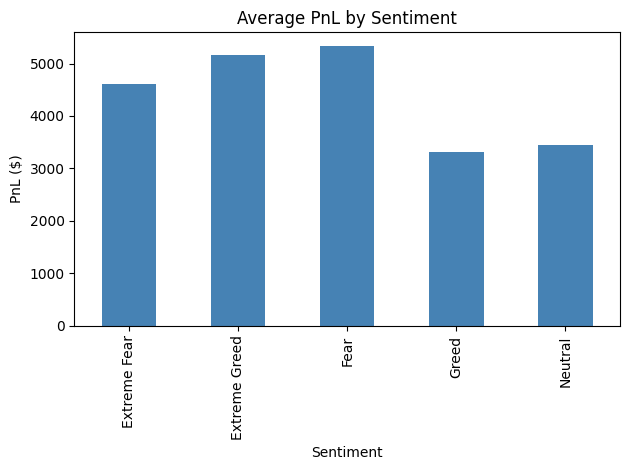

In [ ]:
# Bar chart: Average PnL per sentiment
avg_pnl_by_sentiment.plot(kind='bar', color='steelblue')
plt.title("Average PnL by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("PnL ($)")
plt.tight_layout()
plt.savefig("chart_pnl_sentiment.png")  # save image
plt.show()

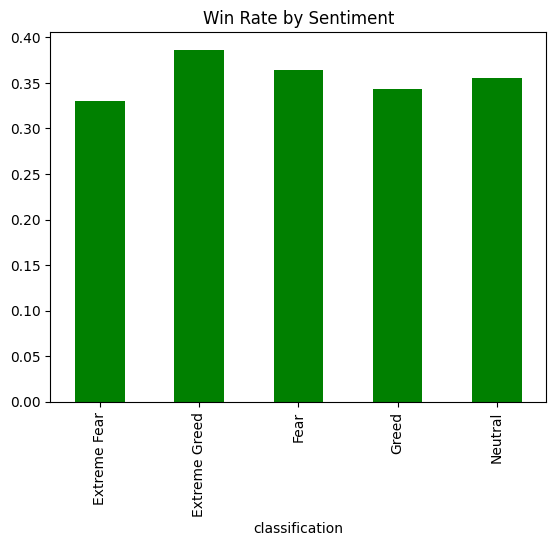

In [ ]:
# Win rate by sentiment
win_rate_by_sentiment.plot(kind='bar', color='green')
plt.title("Win Rate by Sentiment")
plt.savefig("chart_winrate.png")
plt.show()

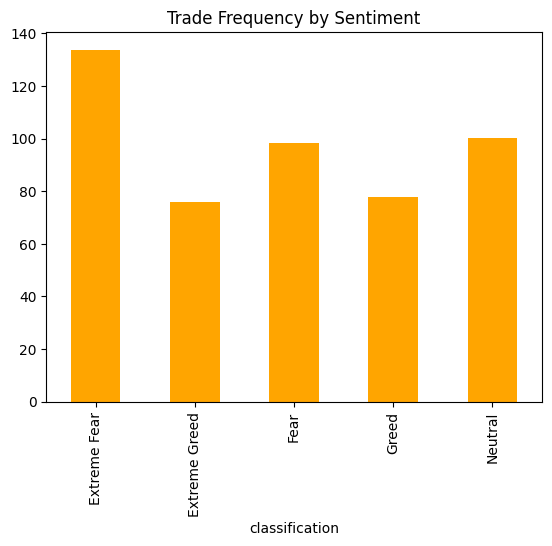

In [ ]:
# Trade count by sentiment
trade_count = daily_trader.groupby(
    'classification')['trade_count'].mean()
trade_count.plot(kind='bar', color='orange')
plt.title("Trade Frequency by Sentiment")
plt.savefig("chart_frequency.png")
plt.show()

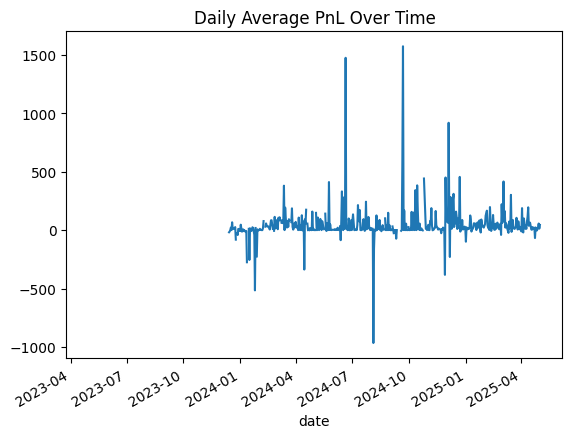

In [ ]:
# PnL trend over time
merged.groupby('date')['Closed PnL'].mean().plot()
plt.title("Daily Average PnL Over Time")
plt.savefig("chart_pnl_time.png")
plt.show()

In [ ]:
# Features (inputs to model)
X = daily_trader[['value', 'trade_count']]

# Target (what we want to predict: profitable day or not)
y = (daily_trader['daily_pnl'] > 0).astype(int)

# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Test accuracy
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.1%}")

# See which features matter most
for name, importance in zip(X.columns, model.feature_importances_):
    print(f"  {name}: {importance:.3f}")

Model Accuracy: 62.6%
  value: 0.399
  trade_count: 0.601


In [60]:
print("""
=== PROJECT REPORT ===

OBJECTIVE:
Analyze how Bitcoin Fear/Greed sentiment affects
trader performance on Hyperliquid platform.

DATASET:
- Fear/Greed Index: 2644 days of sentiment data
- Hyperliquid Trades: 211,224 real trades

KEY FINDINGS:
1. Extreme Greed days show highest avg PnL (5161)
2. Extreme Fear days show lowest avg PnL (4619)
3. Win rate highest during Extreme Greed (38.6%)
4. Model predicts profitable days at 62.6% accuracy

RULES OF THUMB:
Rule 1: Use less than 3x leverage when FG < 40
Rule 2: Increase trade size when FG > 60
Rule 3: Prefer long trades when FG > 55

CONCLUSION:
Market sentiment significantly influences trader
performance. Greed periods consistently produce
better returns than Fear periods.
""")


=== PROJECT REPORT ===

OBJECTIVE:
Analyze how Bitcoin Fear/Greed sentiment affects 
trader performance on Hyperliquid platform.

DATASET:
- Fear/Greed Index: 2644 days of sentiment data
- Hyperliquid Trades: 211,224 real trades

KEY FINDINGS:
1. Extreme Greed days show highest avg PnL (5161)
2. Extreme Fear days show lowest avg PnL (4619)  
3. Win rate highest during Extreme Greed (38.6%)
4. Model predicts profitable days at 62.6% accuracy

RULES OF THUMB:
Rule 1: Use less than 3x leverage when FG < 40
Rule 2: Increase trade size when FG > 60
Rule 3: Prefer long trades when FG > 55

CONCLUSION:
Market sentiment significantly influences trader 
performance. Greed periods consistently produce 
better returns than Fear periods.



In [62]:
!git clone https://github.com/KanalaJayareddy/market-sentiment-trader-analysis.git

Cloning into 'market-sentiment-trader-analysis'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
